In [1]:
import torch
from torch import nn

device = "mps" if torch.backends.mps.is_available() else "cpu"
device

'mps'

In [2]:
from pathlib import Path
data_path = Path("prepared_data/foods-101/")
train_path = data_path / "train"
test_path = data_path / "test"

train_path, test_path

(PosixPath('prepared_data/foods-101/train'),
 PosixPath('prepared_data/foods-101/test'))

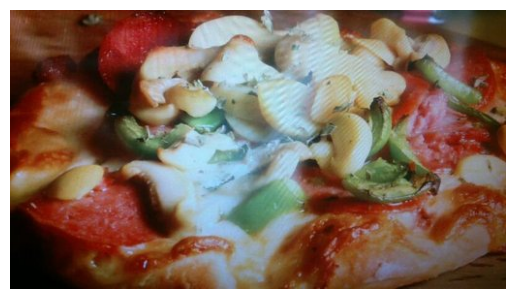

In [3]:
import random 
from PIL import Image
import matplotlib.pyplot as plt

random.seed(42)

image_path_list = list(data_path.glob("*/*/*.jpg"))

random_image = random.choice(image_path_list)

with Image.open(random_image) as f:
    plt.imshow(f)
    plt.axis("off")




In [4]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [32]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(31),
    transforms.ToTensor()
])

In [33]:
train_dataset = datasets.ImageFolder(root=train_path,
                                     transform=test_transform,
                                     target_transform=None)
test_dataset = datasets.ImageFolder(root=test_path,
                                    transform=transform,
                                    target_transform=None)
train_dataset, test_dataset

(Dataset ImageFolder
     Number of datapoints: 2250
     Root location: prepared_data/foods-101/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 750
     Root location: prepared_data/foods-101/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [34]:
class_names = train_dataset.classes
class_dict = train_dataset.class_to_idx

len(class_names), len(class_dict), len(train_dataset), len(test_dataset)

(3, 3, 2250, 750)

(<matplotlib.image.AxesImage at 0x31aa770e0>, 'pizza', torch.Size([3, 64, 64]))

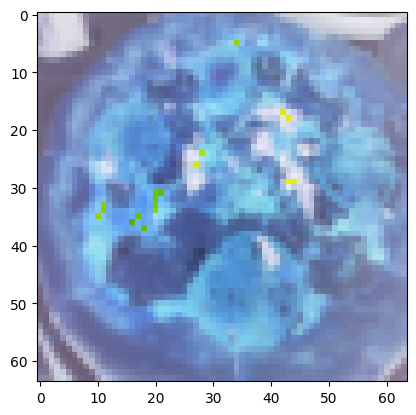

In [35]:
import os

BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=os.cpu_count())

test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=os.cpu_count())

img, label = train_dataset[0][0], train_dataset[0][1]

plt.imshow(img.permute(1, 2, 0)), class_names[label], img.shape

In [36]:
print(len(train_dataloader), len(test_dataloader))

71 24


In [40]:
class TinyVGG(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, 
                         stride=2)
        )

        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.block_3 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        return self.block_3(self.block_2(self.block_1(x)))
    
torch.manual_seed(42)
model = TinyVGG(input_shape=3,
                hidden_units=20,
                output_shape=len(train_dataset.classes))

torch.manual_seed(42)
model2 = TinyVGG(input_shape=3,
                 hidden_units=40,
                 output_shape=len(train_dataset.classes))
model2.to(device)

TinyVGG(
  (block_1): Sequential(
    (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_3): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=10240, out_features=3, bias=True)
  )
)

In [41]:
from torchinfo import summary

summary(model, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 20, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 20, 64, 64]           560
│    └─ReLU: 2-2                         [1, 20, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 20, 64, 64]           3,620
│    └─ReLU: 2-4                         [1, 20, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 20, 32, 32]           --
├─Sequential: 1-2                        [1, 20, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 20, 32, 32]           3,620
│    └─ReLU: 2-7                         [1, 20, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 20, 32, 32]           3,620
│    └─ReLU: 2-9                         [1, 20, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 20, 16, 16]           --
├─Seq

In [42]:
device = "mps" if torch.backends.mps.is_available() else "cpu"

model.to(device)

TinyVGG(
  (block_1): Sequential(
    (0): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_3): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=5120, out_features=3, bias=True)
  )
)

In [43]:
def train_step(model: torch.nn.Module,
               train_dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    model.train()

    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)
        
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    return train_loss, train_acc

In [45]:
def test_step(model: torch.nn.Module,
              test_dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    model.eval()

    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        for batch, (X, y) in enumerate(test_dataloader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            test_loss += loss.item()
            y_pred_label = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            test_acc += ((y_pred_label == y).sum().item()/len(y_pred_label))
    
    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)
    return test_loss, test_acc

In [46]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          epochs: int):
    results = {"train_loss": [], 
               "train_acc": [], 
               "test_loss": [], 
               "test_acc": []}
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           train_dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        
        test_loss, test_acc = test_step(model=model,
                                        test_dataloader=test_dataloader,
                                        loss_fn=loss_fn)
        
        print(f"Epoch: {epoch + 1}")
        print(f"Train loss: {train_loss:.2f} | Train acc: {train_acc:.2f}")
        print(f"Test loss: {test_loss:.2f} | Test acc: {test_acc:.2f}")
        
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
    return results
        

In [47]:
torch.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=0.001)

In [48]:
torch.manual_seed(42)

training_results = train(model=model,
                         train_dataloader=train_dataloader,
                         test_dataloader=test_dataloader,
                         loss_fn=loss_fn,
                         optimizer=optimizer,
                         epochs=5)

  0%|          | 0/5 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x130175da0>
Traceback (most recent call last):
  File "/Users/kazikgarstecki/Desktop/pytorch_workspace/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/Users/kazikgarstecki/Desktop/pytorch_workspace/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1568, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/opt/homebrew/Cellar/python@3.12/3.12.8/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Cellar/python@3.12/3.12.8/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^

KeyboardInterrupt: 

In [49]:
torch.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model2.parameters(),
                             lr=0.001)

In [30]:
model_2_results = train(model2, train_dataloader, test_dataloader, loss_fn, optimizer, 5)

 20%|██        | 1/5 [01:50<07:21, 110.39s/it]

Epoch: 1
Train loss: 1.04 | Train acc: 0.45
Test loss: 0.95 | Test acc: 0.51


 40%|████      | 2/5 [03:38<05:26, 108.81s/it]

Epoch: 2
Train loss: 0.97 | Train acc: 0.51
Test loss: 1.07 | Test acc: 0.54


 60%|██████    | 3/5 [05:25<03:36, 108.38s/it]

Epoch: 3
Train loss: 0.96 | Train acc: 0.53
Test loss: 0.85 | Test acc: 0.62


In [31]:
model_2_results

NameError: name 'model_2_results' is not defined